<a href="https://colab.research.google.com/github/toddlack/colab/blob/main/Easy_Lora_Trainer_SDA_SD1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Easy LoRA trainer SD 1.5 - Stable Diffusion Art
### [Guide to use this notebook](https://stable-diffusion-art.com/train-lora/) - Leave comment if you have questions. Speicfy you are using the SD 1.5 LoRA training notebook. Paste the error message.


## Log
- 07/11/2024: Added apt update
- 07/06/2024: Use venv
- 03/15/2024: Bug fix. Add LoRA image generation
- 02/07/2024: 1-click Easy trainer
- 01/30/2024: Bug fix


In [ ]:
#@title <font size="5" color="orange"> Upload images and start training </font>
#@markdown Begineers: Use a different `Project_folder` each time when you upload the images.
from google.colab import drive
drive.mount('/content/drive')

Project_folder = 'AI_PICS/training/AndyLau' #@param {type:"string"}
pretained_model_name = 'stable-diffusion-v1-5/stable-diffusion-v1-5' #@param {type:"string"}
Image_repeats = 100 #@param {type:"integer"}
Number_of_epoches = 1 #@param {type:"integer"}
Learning_rate = 0.0001 #@param {type:"number"}
Triggering_keyword = 'Andy Lau' #@param {type:"string"}
Lora_name = 'AndyLau001' #@param {type:"string"}
Lora_output_path = 'AI_PICS/Lora' #@param {type:"string"}
Skip_image_upload = False #@param {type:"boolean"}
#@markdown Image repeats has no effect if you skip image upload.

# construct paths
projectPath = '/content/drive/MyDrive/' + Project_folder
imagePath = projectPath + '/' + str(Image_repeats) + '_'+ Lora_name
loraPath = '/content/drive/MyDrive/' + Lora_output_path

!mkdir -p {loraPath}


def install():
  !/content/venv/bin/pip list | grep bitsandbytes > /content/bitsandbytespip.txt
  with open('/content/bitsandbytespip.txt', 'r') as file:
      if 'bitsandbytes' in file.read():
        print('Already installed.')
        %cd /content/kohya_ss/
        return

  print('Installing...')

  # Install requirements
  !apt update
  !apt install python3.10-venv
  %cd /content/
  !python -m venv venv
  !/content/venv/bin/pip install torch==2.0.1+cu117 torchvision -f https://download.pytorch.org/whl/torch_stable.html
  !/content/venv/bin/pip install dadaptation==3.1 diffusers[torch]==0.24.0 easygui==0.98.3 einops==0.6.0 fairscale==0.4.13 ftfy==6.1.1 gradio==3.36.1 huggingface-hub==0.23.4
  !/content/venv/bin/pip install accelerate==0.32.1 lion-pytorch==0.0.6 lycoris_lora==1.8.0.dev6 open-clip-torch==2.20.0 prodigyopt==1.0 pytorch-lightning==1.9.0 safetensors==0.3.1 timm==0.6.12
  !/content/venv/bin/pip install tk==0.1.0 transformers==4.30.2 voluptuous==0.13.1 wandb==0.15.0 xformers==0.0.20 omegaconf toml==0.10.2 opencv-python==4.10.0.84


  # Install bitsandbytes
  !git clone -b 0.41.0 https://github.com/TimDettmers/bitsandbytes
  %cd /content/bitsandbytes
  !CUDA_VERSION=118 make cuda11x
  !/content/venv/bin/python setup.py install

  # Install kohya
  %cd /content
  !git clone -b v21.8.9 https://github.com/bmaltais/kohya_ss.git
  %cd kohya_ss/

  # update torchvision to a compatible version
  #!pip install torch==2.0.1+cu117 torchvision -f https://download.pytorch.org/whl/torch_stable.html

  # add pwd to python path or else blip captioning won't work
  %env PYTHONPATH=/env/python:/content/kohya_ss


if not Skip_image_upload:
  # upload images
  import os
  from google.colab import files
  import shutil
  if os.path.exists(projectPath):
    raise Exception(f'Error: Project folder {Project_folder} already exists. Please use a different project folder name. \n')
  else:
    !mkdir -p {imagePath}
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = imagePath + '/' + filename
        shutil.move(filename, dst_path)
    print('Images uploaded successfully.\n')




install()

# auto-captioning
if not Skip_image_upload:
  !/content/venv/bin/python3 "finetune/make_captions.py" --batch_size="1" --num_beams="1"\
                          --top_p="0.9" --max_length="75" --min_length="20" --beam_search\
                          --caption_extension=".txt"\
                          {imagePath}\
                          --caption_weights="https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth"
  # Add preflix to captions
  import glob
  for file in glob.glob(imagePath + "/*.txt"):
    with open(file, 'r') as f:
        original = f.read()
    with open(file, 'w') as f:
        f.write(Triggering_keyword + ', ' + original)
    with open(file, 'r') as f:
        print(f.read())

# Run training
!/content/venv/bin/accelerate launch --num_cpu_threads_per_process=2 "./train_network.py"     \
                         --enable_bucket --min_bucket_reso=256 --max_bucket_reso=2048               \
                         --pretrained_model_name_or_path={pretained_model_name}           \
                         --train_data_dir={projectPath}         \
                         --resolution="512,650" --output_dir={loraPath}  \
                         --network_alpha="64" --save_model_as=safetensors                           \
                         --network_module=networks.lora --text_encoder_lr=5e-05 --unet_lr={Learning_rate}    \
                         --network_dim=64 --output_name={Lora_name} --lr_scheduler_num_cycles="1"        \
                         --no_half_vae --learning_rate={Learning_rate} --lr_scheduler="constant"           \
                         --train_batch_size="3" --max_train_steps="100000" --save_every_n_epochs="99999"   \
                         --mixed_precision="fp16" --save_precision="fp16" --seed="1234"             \
                         --caption_extension=".txt" --cache_latents --optimizer_type="AdamW"        \
                         --max_data_loader_n_workers="1" --clip_skip=2 --bucket_reso_steps=64       \
                         --max_train_epochs={Number_of_epoches}\
                         --mem_eff_attn --xformers --bucket_no_upscale --noise_offset=0.05

Mounted at /content/drive


Saving 6dd8ca3857efc3fb32ffc0becb95af60.jpg to 6dd8ca3857efc3fb32ffc0becb95af60.jpg
Saving b5a6629bf3f3448caacaa39bcb927c6f.jpeg to b5a6629bf3f3448caacaa39bcb927c6f.jpeg
Saving d61202b6b2ab508b347f00dd351b62df.jpeg to d61202b6b2ab508b347f00dd351b62df.jpeg
Saving 774b72b6-8d47-4314-b182-3f86fa63dd5b_0c53b464.png to 774b72b6-8d47-4314-b182-3f86fa63dd5b_0c53b464.png
Saving 1474.png to 1474.png
Saving 201729_full.png to 201729_full.png
Saving 972149fe53be497abe01fd4624e392a0.png to 972149fe53be497abe01fd4624e392a0.png
Saving 169102330-674x420.png to 169102330-674x420.png
Saving AndyLau1-480x320.png to AndyLau1-480x320.png
Saving eYYxyq_2f.png to eYYxyq_2f.png
Saving image (1).png to image (1).png
Saving LmpwZWc.png to LmpwZWc.png
Saving media.baselineresearch.png to media.baselineresearch.png
Saving media.baselineresearch2.png to media.baselineresearch2.png
Saving MV5BNTMxY2EzYmQtMDkzMC00ZTdiLTgxYjMtZWUyNTBlYjU4MzYxXkEyXkFqcGdeQXVyMjQwMjk0NjI@._V1_.png to MV5BNTMxY2EzYmQtMDkzMC00ZTdiLTgxYj

rm: cannot remove '/content/*.png': No such file or directory
/content/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 13 files:   0% 0/13 [00:00<?, ?it/s]
tokenizer/merges.txt:   0% 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json: 100% 472/472 [00:00<00:00, 4.09MB/s]


tokenizer/vocab.json:   0% 0.00/1.06M [00:00<?, ?B/s]


tokenizer/tokenizer_config.json: 100% 806/806 [00:00<00:00, 7.24MB/s]
tokenizer/vocab.json: 100% 1.06M/1.06M [00:00<00:00, 15.8MB/s]

tokenizer/merges.txt: 100% 525k/525k [00:00<00:00, 2.58MB/s]
Fetching 13 files: 100% 13/13 [00:00<00:00, 34.07it/s]
Loading pipeline components...: 100% 6/6 [00:12<00:00,  2.04s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_dif

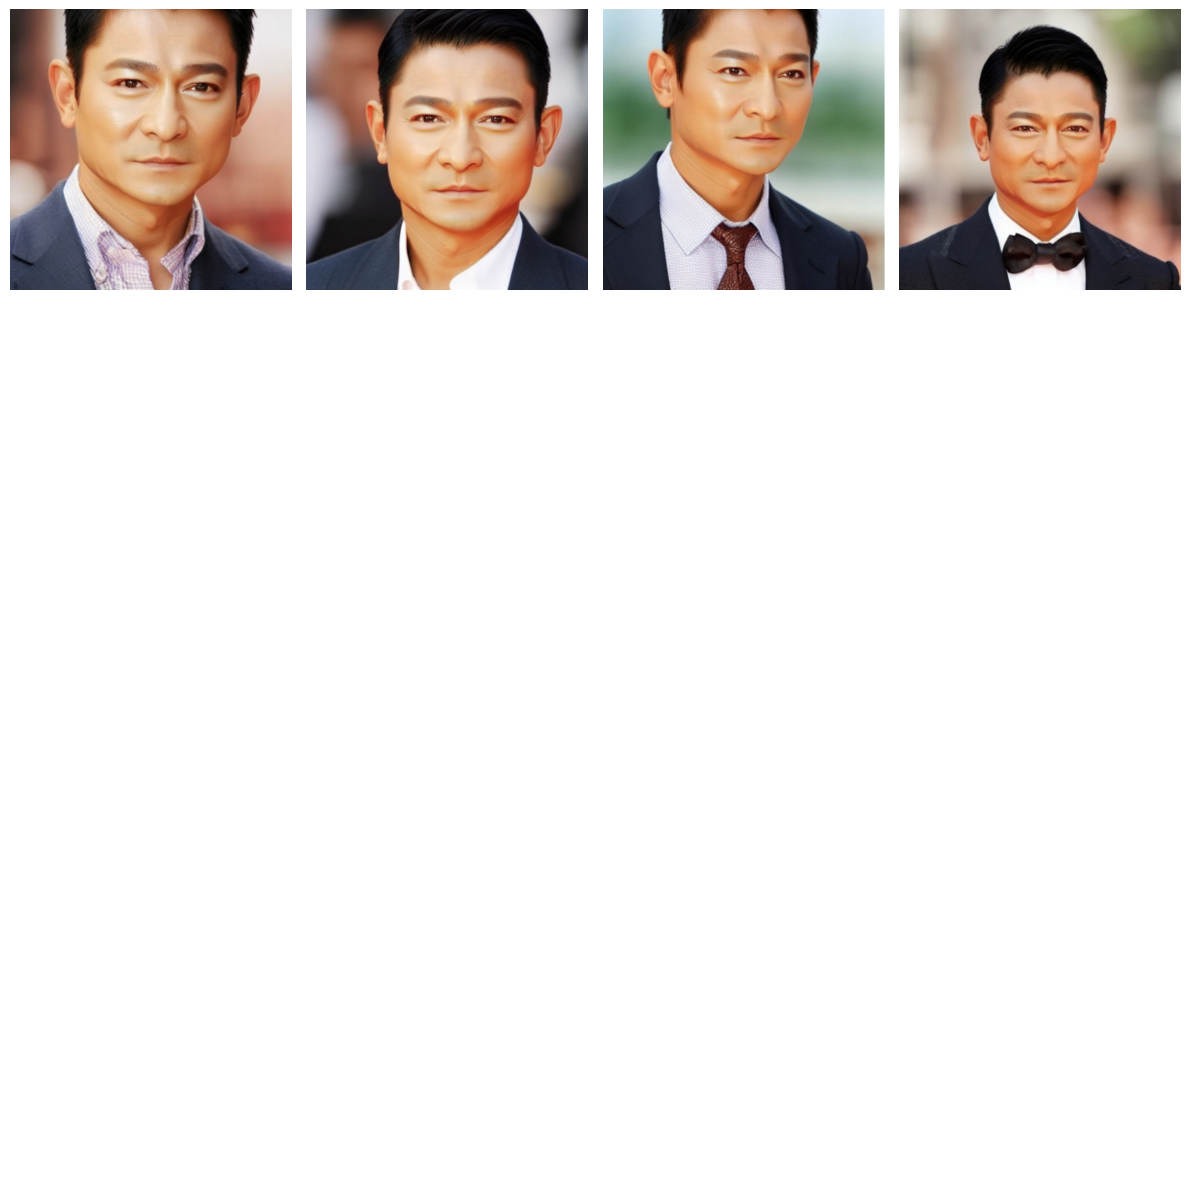

In [ ]:
#@title Test image generation from LoRA

prompt = "Photo of Andy Lau" #@param {type:"string"}
negative_prompt = "disfigured, deformed" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 25 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 101 #@param {type:"number"}

!rm /content/*.png


cmd= f'''
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np
import torch

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained("{pretained_model_name}", safety_checker=None, torch_dtype=torch.float16)
  pipe.load_lora_weights("{loraPath}"+'/'+"{Lora_name}" + '.safetensors')
  pipe.to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed({seed})

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        "{prompt}",
        height={height},
        width={width},
        negative_prompt="{negative_prompt}",
        num_images_per_prompt={num_samples},
        num_inference_steps={num_inference_steps},
        guidance_scale={guidance_scale},
        generator=g_cuda
    ).images

    print(images)

    for i, im in enumerate(images):
      im.save("/content/"+str(i)+".png")
'''

with open("/content/generate_image.py", "w") as file:
    # Write the string to the file
    file.write(cmd)

!/content/venv/bin/python3  /content/generate_image.py


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Function to display a grid of images
def display_image_grid(image_paths, grid_size):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()

    for img_path, ax in zip(image_paths, axes):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    # Hide any remaining empty subplots
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# List of image paths (replace with your image paths)
image_folder = '/content/'
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')]

# Display the images in a 3x3 grid (modify grid_size as needed)
grid_size = (4, 4)
display_image_grid(image_paths, grid_size)
